In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from sklearn.linear_model import LinearRegression

import joblib

# Load data
df = pd.read_csv('../data/clean_listings.csv')

# Recreate features (same as Day 3)
# Ensure same feature columns exist: Size_SQM, Bedrooms_Num, Bathrooms_Num, Amenity_Count, and location dummies.
# If you saved the feature matrix from Day 3, you can load it; otherwise, recreate.



# Handle missing values 
print("Missing values before imputation:", df[['Size_SQM', 'Bedrooms_Num', 'Bathrooms_Num']].isnull().sum())
median_bathrooms = df['Bathrooms_Num'].median()
df['Bathrooms_Num'] = df['Bathrooms_Num'].fillna(median_bathrooms)


# Top 10 locations dummies
top_locs = df['Location'].value_counts().head(10).index
for loc in top_locs:
    df[f'Loc_{loc}'] = (df['Location'] == loc).astype(int)

feature_cols = ['Size_SQM', 'Bedrooms_Num', 'Bathrooms_Num', 'Amenity_Count'] + [f'Loc_{loc}' for loc in top_locs]
X = df[feature_cols].fillna(0)
y = np.log(df['Price_Millions'])

print("Feature matrix shape:", X.shape)


Missing values before imputation: Size_SQM          0
Bedrooms_Num      0
Bathrooms_Num    13
dtype: int64
Feature matrix shape: (359, 14)


In [24]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# ==========================================================================
# TRAINING RANDOM FOREST - fine-tuning for later
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred_train_rf = rf.predict(X_train)
y_pred_test_rf = rf.predict(X_test)

# Evaluate
mae_train_rf = mean_absolute_error(y_train, y_pred_train_rf)
rmse_train_rf = np.sqrt(mean_squared_error(y_train, y_pred_train_rf))
r2_train_rf = r2_score(y_train, y_pred_train_rf)

mae_test_rf = mean_absolute_error(y_test, y_pred_test_rf)
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_pred_test_rf))
r2_test_rf = r2_score(y_test, y_pred_test_rf)

print("Random Forest Performance:")
print(f"Train MAE: {mae_train_rf:.2f}M, RMSE: {rmse_train_rf:.2f}M, R²: {r2_train_rf:.3f}")
print(f"Test MAE: {mae_test_rf:.2f}M, RMSE: {rmse_test_rf:.2f}M, R²: {r2_test_rf:.3f}")

Random Forest Performance:
Train MAE: 7.67M, RMSE: 12.36M, R²: 0.951
Test MAE: 17.53M, RMSE: 27.85M, R²: 0.703


In [26]:
# Hyperparameter tuning with GridSearchCV - data is small but will help improve performance
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Best parameters:", grid_rf.best_params_)
best_rf = grid_rf.best_estimator_

# Evaluate tuned model
y_pred_test_rf_tuned = best_rf.predict(X_test)
mae_test_rf_tuned = mean_absolute_error(y_test, y_pred_test_rf_tuned)
rmse_test_rf_tuned = np.sqrt(mean_squared_error(y_test, y_pred_test_rf_tuned))
r2_test_rf_tuned = r2_score(y_test, y_pred_test_rf_tuned)

print(f"Tuned RF Test MAE: {mae_test_rf_tuned:.2f}M, RMSE: {rmse_test_rf_tuned:.2f}M, R²: {r2_test_rf_tuned:.3f}")

Best parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
Tuned RF Test MAE: 17.67M, RMSE: 27.20M, R²: 0.717


In [27]:
# =============================================================
# TRAINING XGBoost - good for tabular data and often outperforms RF
# fine-tune later with early stopping and more parameters, grid search or random search

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=100)
xgb_model.fit(X_train, y_train)

y_pred_train_xgb = xgb_model.predict(X_train)
y_pred_test_xgb = xgb_model.predict(X_test)

mae_train_xgb = mean_absolute_error(y_train, y_pred_train_xgb)
rmse_train_xgb = np.sqrt(mean_squared_error(y_train, y_pred_train_xgb))
r2_train_xgb = r2_score(y_train, y_pred_train_xgb)

mae_test_xgb = mean_absolute_error(y_test, y_pred_test_xgb)
rmse_test_xgb = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))
r2_test_xgb = r2_score(y_test, y_pred_test_xgb)

print("\nXGBoost Performance:")
print(f"Train MAE: {mae_train_xgb:.2f}M, RMSE: {rmse_train_xgb:.2f}M, R²: {r2_train_xgb:.3f}")
print(f"Test MAE: {mae_test_xgb:.2f}M, RMSE: {rmse_test_xgb:.2f}M, R²: {r2_test_xgb:.3f}")


XGBoost Performance:
Train MAE: 2.34M, RMSE: 7.16M, R²: 0.983
Test MAE: 17.57M, RMSE: 29.42M, R²: 0.668


In [28]:
# ===============================================================
# Train Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions
y_pred_test_lr = lr.predict(X_test)

# Metrics
mae_test_lr = mean_absolute_error(y_test, y_pred_test_lr)
rmse_test_lr = np.sqrt(mean_squared_error(y_test, y_pred_test_lr))
r2_test_lr = r2_score(y_test, y_pred_test_lr)

print("\nLinear Regression Performance:")
print(f"Test MAE: {mae_test_lr:.2f}M, RMSE: {rmse_test_lr:.2f}M, R²: {r2_test_lr:.3f}")


Linear Regression Performance:
Test MAE: 18.01M, RMSE: 21.89M, R²: 0.816


In [29]:
# =======================================================================================================

# COMPARE ALL MODELS - on table - use tuned RF values for fair comparison
comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Tuned Random Forest', 'XGBoost'],
    'Test MAE (M KSh)': [mae_test_lr, mae_test_rf, mae_test_rf_tuned, mae_test_xgb],
    'Test RMSE (M KSh)': [rmse_test_lr, rmse_test_rf, rmse_test_rf_tuned, rmse_test_xgb],
    'Test R²': [r2_test_lr, r2_test_rf, r2_test_rf_tuned, r2_test_xgb]
})
print(comparison)

                 Model  Test MAE (M KSh)  Test RMSE (M KSh)   Test R²
0    Linear Regression         18.012151          21.894916  0.816300
1        Random Forest         17.530594          27.852798  0.702724
2  Tuned Random Forest         17.671463          27.195509  0.716589
3              XGBoost         17.569037          29.424865  0.668219


In [30]:
# ================================================================================

# Random Forest Text Summary
rf_importance_df = pd.Series(best_rf.feature_importances_, index=feature_cols)
rf_importance_df = rf_importance_df.sort_values(ascending=False)

print("\n" + "="*50)
print("RANDOM FOREST FEATURE IMPORTANCE (TEXT SUMMARY)")

print("\nTop 5 Most Important Features:")
print(rf_importance_df.head(5))

print("\nLeast Important Features:")
print(rf_importance_df.tail(3))

# ****************************** 

# XGBoost Text Summary
xgb_importance_df = pd.Series(xgb_model.feature_importances_, index=feature_cols)
xgb_importance_df = xgb_importance_df.sort_values(ascending=False)

print("\n" + "="*50)
print("XGBOOST FEATURE IMPORTANCE (TEXT SUMMARY)")

print("\nTop 5 Most Important Features:")
print(xgb_importance_df.head(5))

print("\nLeast Important Features:")
print(xgb_importance_df.tail(3))

# ***********************************
# Linear Regression Text Summary
lr_coeff_df = pd.Series(lr.coef_, index=feature_cols)
lr_coeff_df = lr_coeff_df.sort_values(ascending=False)

print("\n" + "="*50)
print("LINEAR REGRESSION COEFFICIENT SUMMARY")

print("\nFeatures Increasing Price the Most:")
print(lr_coeff_df.head(5))

print("\nFeatures Decreasing Price the Most:")
print(lr_coeff_df.tail(5))


RANDOM FOREST FEATURE IMPORTANCE (TEXT SUMMARY)

Top 5 Most Important Features:
Size_SQM         0.512257
Bedrooms_Num     0.210601
Bathrooms_Num    0.085503
Loc_Lavington    0.051417
Loc_Runda        0.049355
dtype: float64

Least Important Features:
Loc_Kitengela        0.003281
Loc_Ongata Rongai    0.001125
Amenity_Count        0.000000
dtype: float64

XGBOOST FEATURE IMPORTANCE (TEXT SUMMARY)

Top 5 Most Important Features:
Loc_Loresho      0.188964
Bedrooms_Num     0.164615
Loc_Runda        0.150759
Loc_Karen        0.126938
Loc_Lavington    0.118490
dtype: float32

Least Important Features:
Loc_Kileleshwa       0.009603
Loc_Ongata Rongai    0.009010
Amenity_Count        0.000000
dtype: float32

LINEAR REGRESSION COEFFICIENT SUMMARY

Features Increasing Price the Most:
Loc_Karen        68.397226
Loc_Runda        61.484097
Loc_Lavington    48.153408
Loc_Loresho      43.849601
Bedrooms_Num      7.449735
dtype: float64

Features Decreasing Price the Most:
Loc_Kiambu Road      -0.811

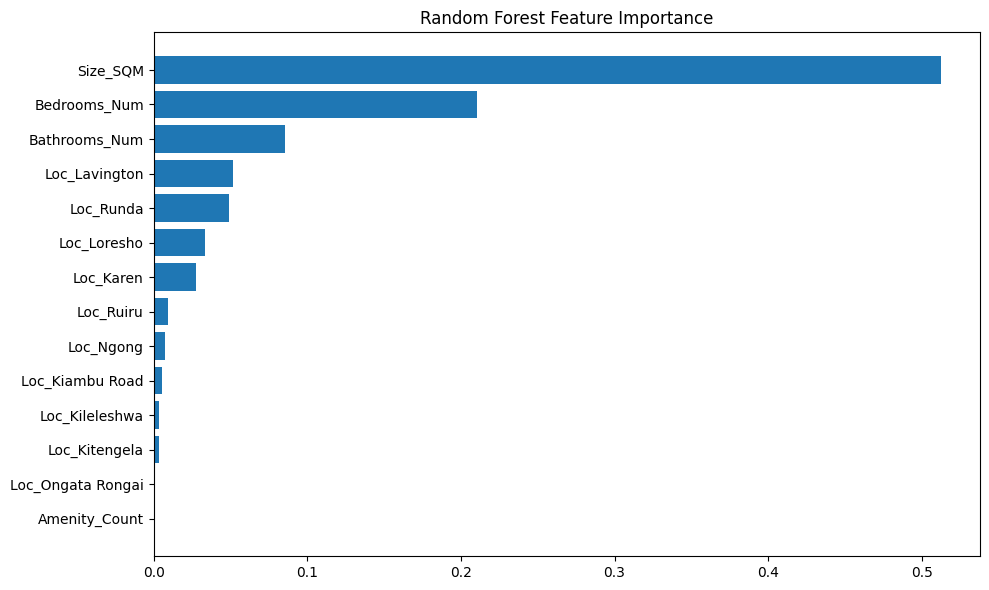

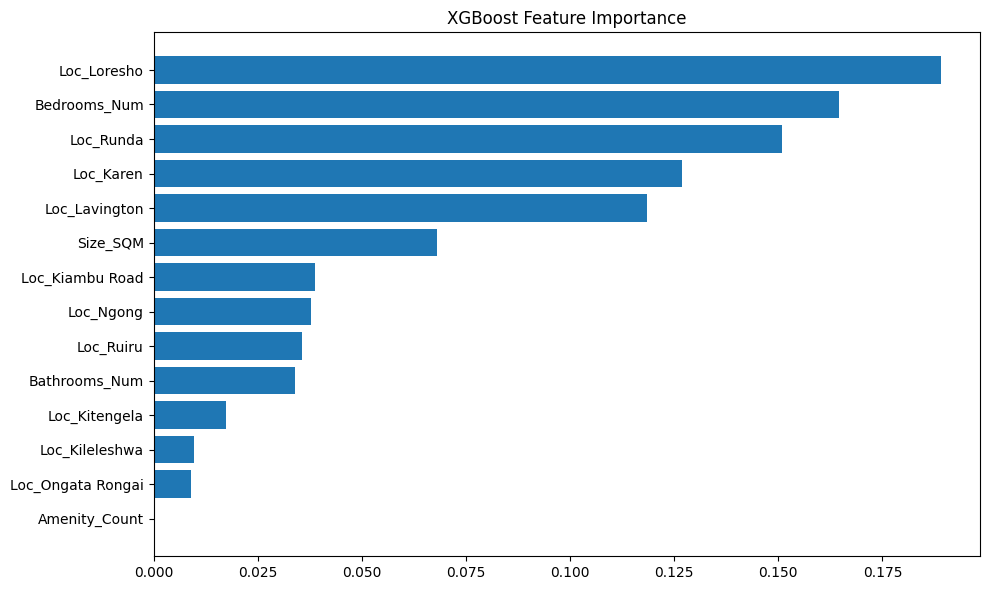

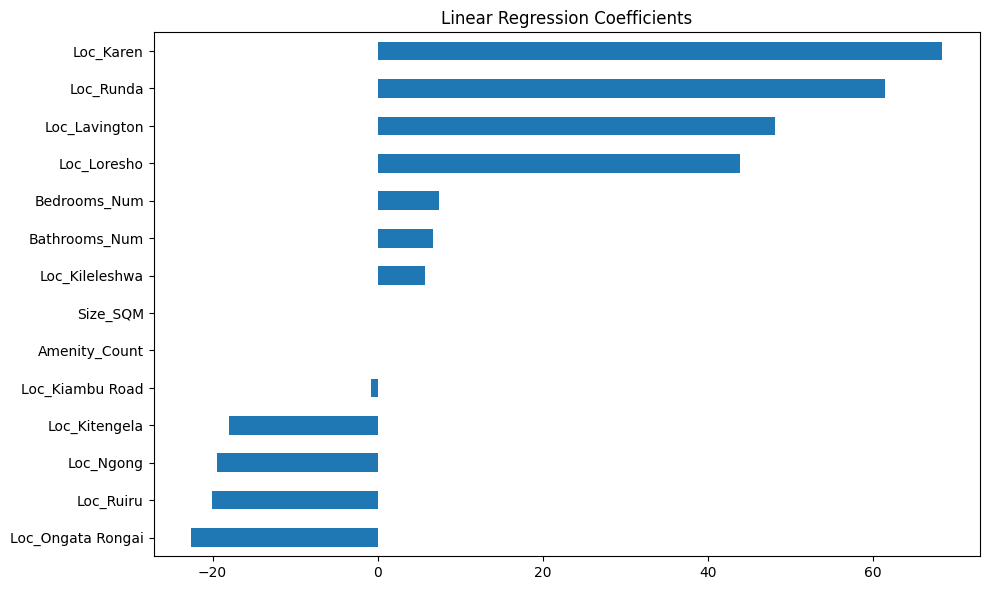

In [31]:
# FEATURE IMPORTANCE PLOTS
# tree-based models like RF and XGBoost provide feature importance scores which can help us understand which features are most influential in predicting house prices.
"""
answer key questions:
    - top features driving predictions
    - are they consistent across models?
    - amenity impact 
    - location impact

"""



# For Random Forest
importances_rf = best_rf.feature_importances_
indices = np.argsort(importances_rf)[::-1]

plt.figure(figsize=(10,6))
plt.title("Random Forest Feature Importance")
plt.barh(range(len(indices)), importances_rf[indices], align='center')
plt.yticks(range(len(indices)), [feature_cols[i] for i in indices])
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../reports/rf_feature_importance.png')
plt.show()

# For XGBoost
importances_xgb = xgb_model.feature_importances_
indices_xgb = np.argsort(importances_xgb)[::-1]

plt.figure(figsize=(10,6))
plt.title("XGBoost Feature Importance")
plt.barh(range(len(indices_xgb)), importances_xgb[indices_xgb], align='center')
plt.yticks(range(len(indices_xgb)), [feature_cols[i] for i in indices_xgb])
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../reports/xgb_feature_importance.png')
plt.show()

# For Linear Regression, use coefficients instead of feature importance
"""Which features increase price
Which decrease price
Strength of impact
"""
coefficients = pd.Series(lr.coef_, index=feature_cols)
coefficients = coefficients.sort_values()

plt.figure(figsize=(10,6))
coefficients.plot(kind='barh')
plt.title("Linear Regression Coefficients")
plt.tight_layout()
plt.show()

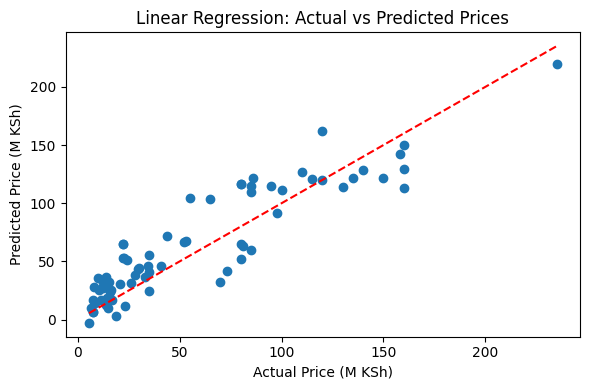

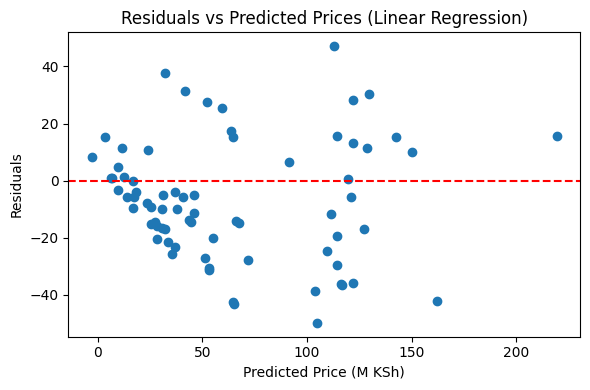

In [35]:
# ===============================================================================================
# ACTUAL VS PREDICTED PLOTS - to visually assess how well the model is performing across the range of prices
"""If points lie close to the red line → good model
If scattered widely → weak model
"""

plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred_test_lr)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Actual Price (M KSh)")
plt.ylabel("Predicted Price (M KSh)")
plt.title("Linear Regression: Actual vs Predicted Prices")
plt.tight_layout()
plt.show()


# RESIDUAL PLOTS - to check for patterns in errors which can indicate model issues like heteroscedasticity or non-linearity
"""Whether errors are random (good)
Or patterned (bad → model missing nonlinear relationships)
"""

residuals = y_test - y_pred_test_lr

plt.figure(figsize=(6,4))
plt.scatter(y_pred_test_lr, residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted Price (M KSh)")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Prices (Linear Regression)")
plt.tight_layout()
plt.show()

In [33]:
models = {
    "Linear Regression": r2_test_lr,
    "Random Forest": r2_test_rf,
    "Tuned Random Forest": r2_test_rf_tuned,
    "XGBoost": r2_test_xgb
}

best_model = max(models, key=models.get)

print(f"\n Best Performing Model: {best_model}")
print(f"With Test R² of: {models[best_model]:.3f}")


 Best Performing Model: Linear Regression
With Test R² of: 0.816


In [34]:
# ==============================================================================
# SAVE BEST MODEL - with LOWEST RMSE for future use

# Select best model based on lowest RMSE instead of highest R² - more intuitive for regression tasks
"""    WHY FOR THIS PROJECT
Random Forest has lower MAE than Linear Regression (17.53 vs 18.01)
But its RMSE is dramatically worse (27.85 vs 21.89)
"""

model_objects = {
    "Linear Regression": (lr, rmse_test_lr),
    "Random Forest": (rf, rmse_test_rf),
    "Tuned Random Forest": (best_rf, rmse_test_rf_tuned),
    "XGBoost": (xgb_model, rmse_test_xgb)
}

best_model_name = min(model_objects, key=lambda x: model_objects[x][1])
best_model_object = model_objects[best_model_name][0]
best_model_rmse = model_objects[best_model_name][1]

print("\n" + "="*50)
print(f"Best Performing Model LOWEST RMSE: {best_model_name}")
print(f"Test RMSE: {best_model_rmse:.2f}M KSh")
print("="*50)

# Save automatically
model_path = f"../models/{best_model_name.replace(' ', '_').lower()}_model.pkl"
joblib.dump(best_model_object, model_path)

print(f"\nBest model saved automatically at: {model_path}")


Best Performing Model LOWEST RMSE: Linear Regression
Test RMSE: 21.89M KSh

Best model saved automatically at: ../models/linear_regression_model.pkl


In [36]:
# save the MAE of the best model for later use in the app
joblib.dump(mae_test_lr, '../models/linear_regression_mae.pkl')

['../models/linear_regression_mae.pkl']

- Although Random Forest achieved a slightly lower MAE, Linear Regression had a much lower RMSE (21.89M vs 27–29M). 
- RMSE penalizes large prediction errors more heavily and is measured in millions of KSh, thus it provides a more intuitive and business-relevant evaluation metric. 

- For house price prediction, minimizing large pricing mistakes is more important than marginal improvements in variance explained. 

- Therefore, the model with the lowest RMSE (Linear Regression) was selected.